0.11705 0.128


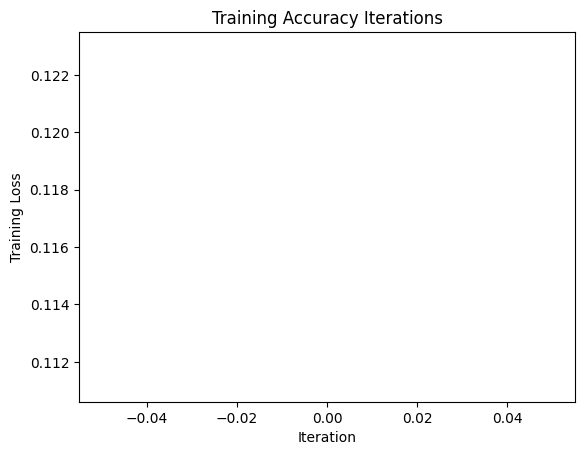

0.9068166666666667 0.9084


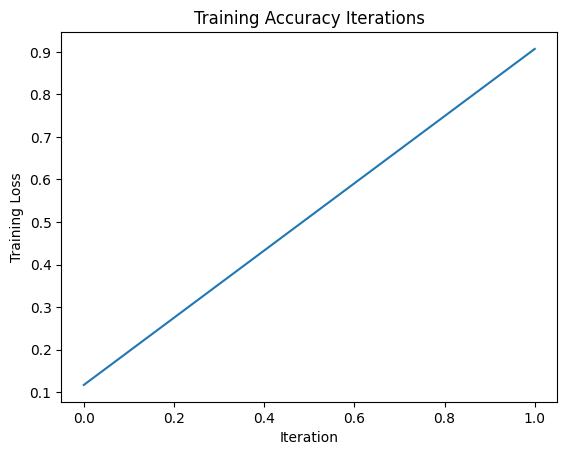

0.92815 0.9276


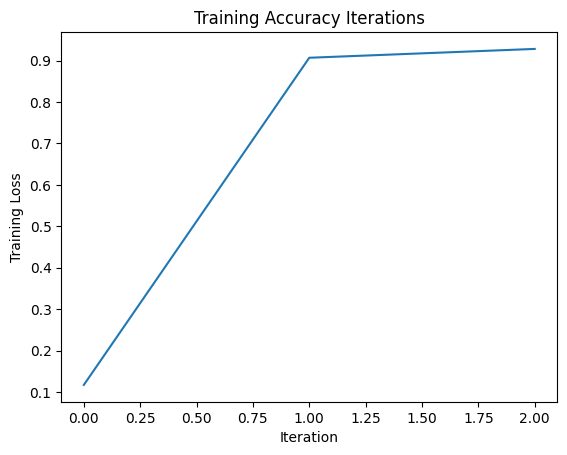

0.9380833333333334 0.9342


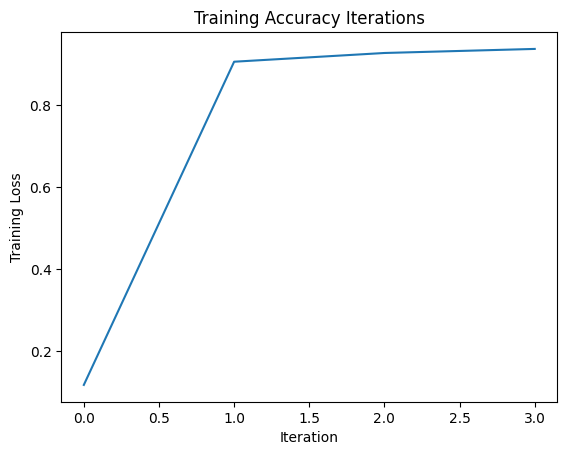

0.9437333333333333 0.9402


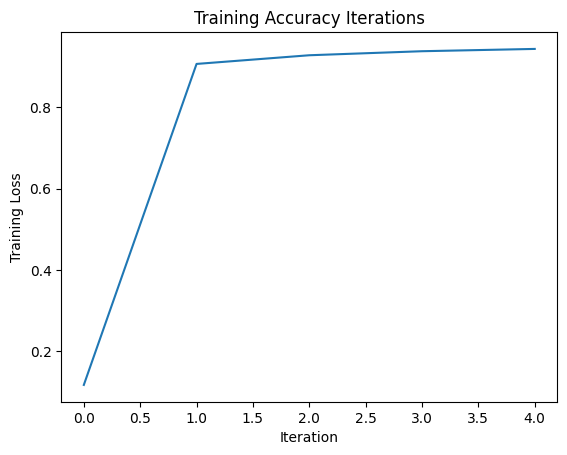

0.9469333333333333 0.9422


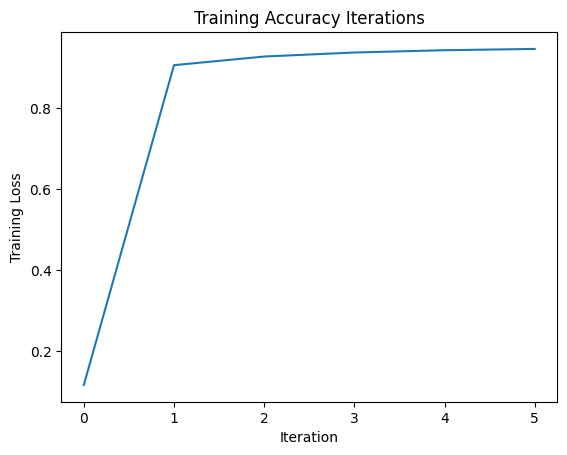

0.9502166666666667 0.9451


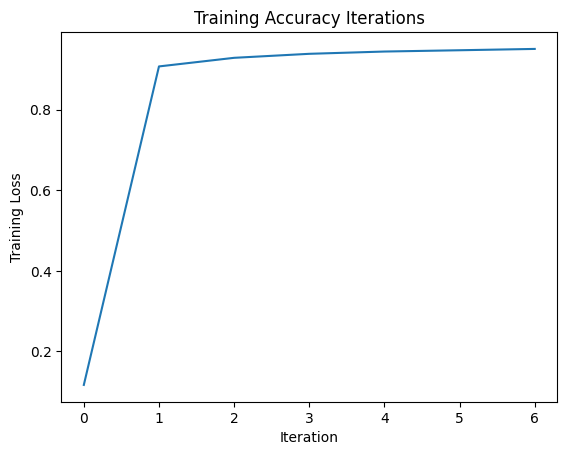

0.9531333333333334 0.9467


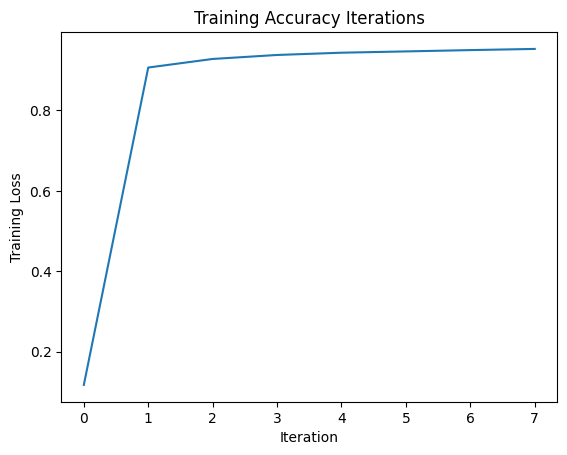

0.95325 0.948


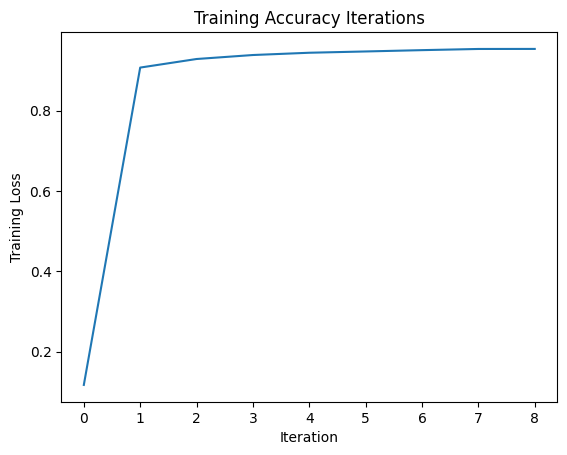

0.9558166666666666 0.95


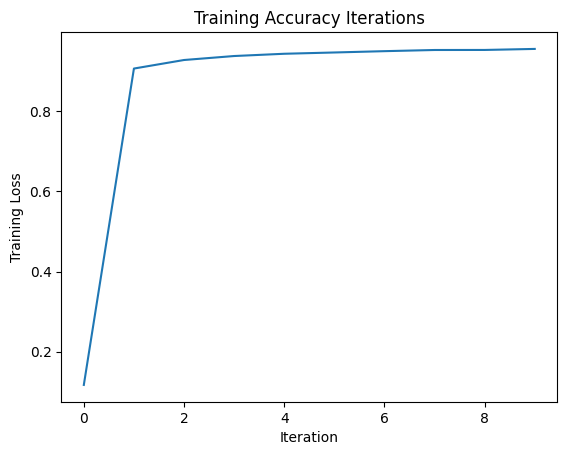

0.9572 0.948


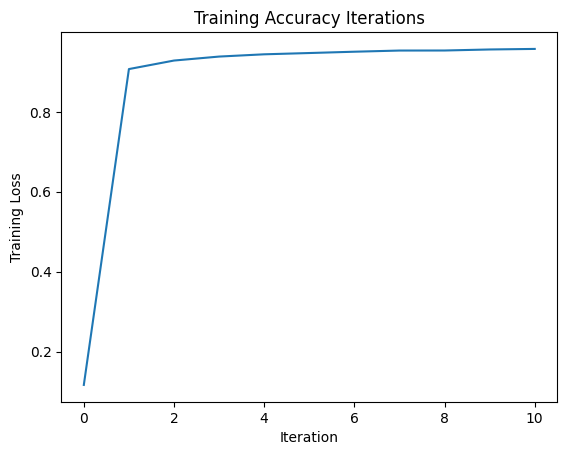

0.9586833333333333 0.9498


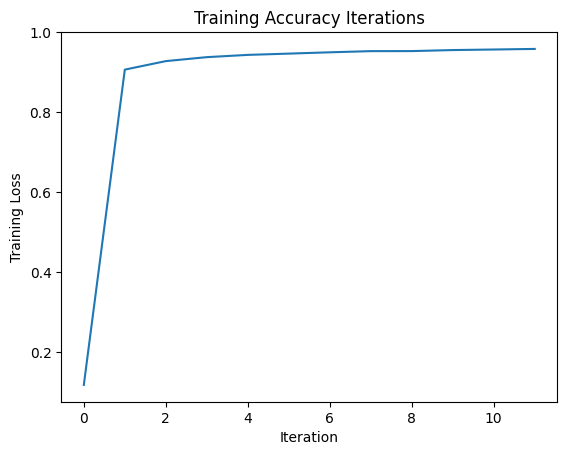

0.9589666666666666 0.9496


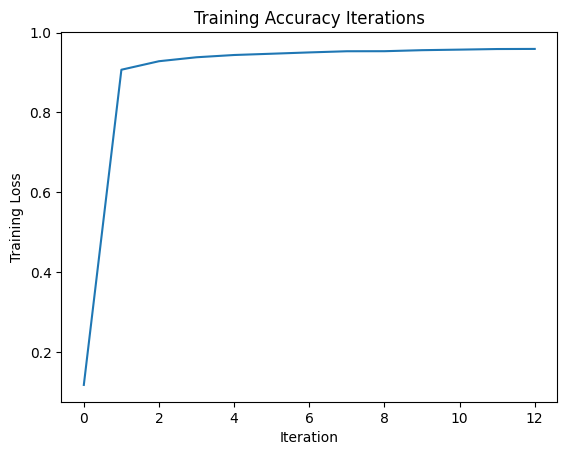

0.9599833333333333 0.9526


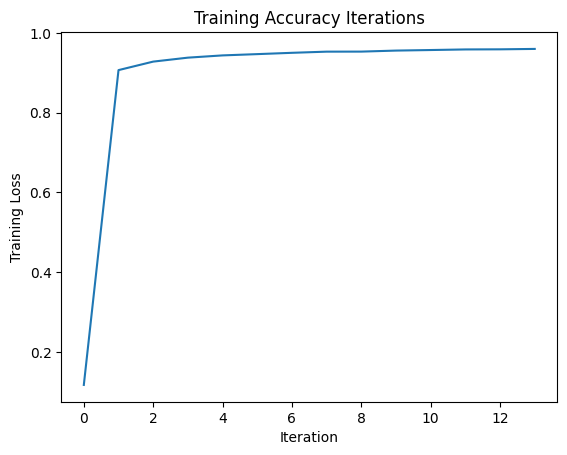

0.96175 0.9518


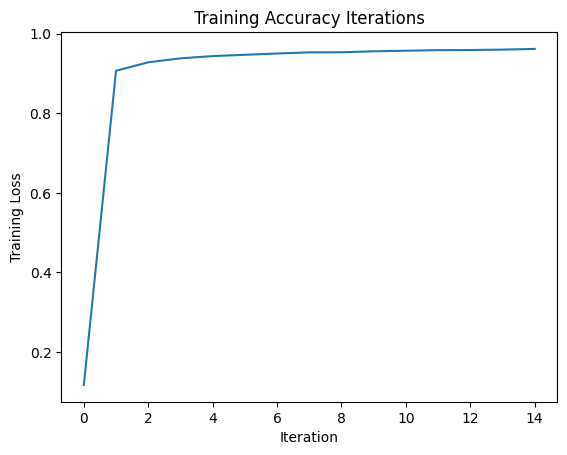

0.96165 0.9515


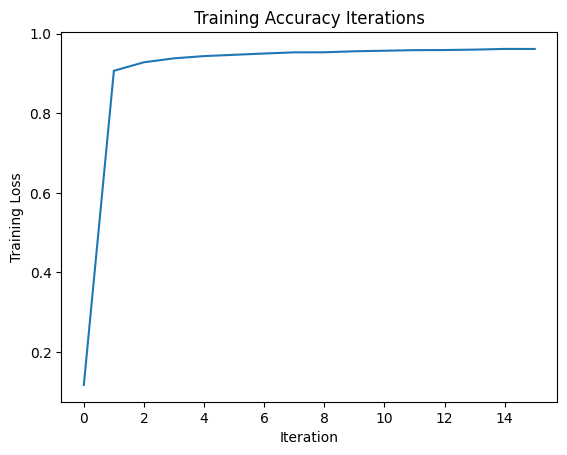

0.9635333333333334 0.9528


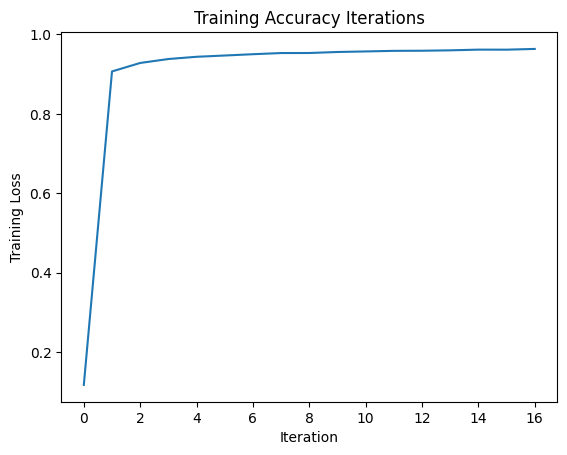

In [246]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict
from dataset.mnist import load_mnist

import matplotlib.pyplot as plt
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *
from common.optimizer import Adam


class TwoLayerNet:

    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, weight_init_std = 0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = np.random.randn(input_size, hidden_size1) / np.sqrt(input_size)
        self.params['b1'] = np.zeros(hidden_size1)
        self.params['W2'] = np.random.randn(hidden_size1, hidden_size2) / np.sqrt(hidden_size1)
        self.params['b2'] = np.zeros(hidden_size2)
        self.params['W3'] = np.random.randn(hidden_size2, output_size) / np.sqrt(hidden_size2)
        self.params['b3'] = np.zeros(output_size)

        
        
        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()


        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])
        self.layers['Relu3'] = Relu()



        
        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy


    # x : 입력 데이터, t : 정답 레이블
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db
        
  
        return grads


        
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size1=14, hidden_size2 = 15,output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.014

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

optimizer = Adam()


def log_to_file(log_file, content):
    with open(log_file, 'a') as f:
        f.write(content + '\n')
log_file = 'accuracy_log.txt'




for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]


    
    # 기울기 계산
    grad = network.gradient(x_batch, t_batch) # 오차역전파법 방식
    
    # 갱신
    optimizer.update(network.params, grad)
    

    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print( train_acc, test_acc)

        log_content = f'Iteration {i+1}: Train Accuracy = {train_acc}, Test Accuracy = {test_acc}'
        log_to_file(log_file, log_content)
        
        plt.plot(train_acc_list)
        plt.xlabel('Iteration')
        plt.ylabel('Training Loss')
        plt.title('Training Accuracy Iterations')
        plt.show()
        
        
